In [697]:
import cv2
import numpy as np
import skimage.io as io
from commonfunctions import *
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

In [698]:
def extract_boundaries(image):
    # Read the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Use the Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)

    return edges

def fill_small_holes(image, kernel_size=3):
    # Read the image
    image = extract_boundaries(image)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Define a kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Perform closing to fill small holes
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Perform erosion
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    eroded_edges = cv2.erode(dilated_edges, kernel, iterations=1)

    return eroded_edges

In [699]:
def auto_rotate_image(image, counter=1):

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and aid contour detection
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_with_contour = image.copy()

    for contour in contours:
        cv2.drawContours(image_with_contour, [contour], -1, (0, 255, 0), 2)

    print(len(contours))
        
    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)
    

    epsilon = 0.005 * cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, epsilon, True)

    #cv2.drawContours(image_with_contour, [approx], -1, (0, 255, 0), 2)
    print('contour drawn')

    # Fit a rotated bounding box to the contour
    rect = cv2.minAreaRect(max_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    #cv2.drawContours(image_with_contour, [box], -1, (0, 255, 0), 2)

    #cv2.circle(image_with_contour, tuple(box[3]), 5, (0, 0, 255), -1)

    angle = rect[2]

    # Unpack the rectangle information
    (center, (width_contour, height_contour), angle) = rect

    # Ensure width is always the larger side
    if width_contour < height_contour:
        width_contour, height_contour = height_contour, width_contour
        angle -= 90

    print(angle)

    #Counter is for the second call of this function, in this call I am interested in getting the new coordinates of the bounding box but no further rotation needed.
    if counter == 0:

        # Rotate the image to the detected angle
        rotated_image = rotating_image(image_with_contour, angle)
    else:
        return image_with_contour, box

    return rotated_image, box

def rotating_image(image, angle):
    # Get the image dimensions
    height, width = image.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

    # Determine the new bounding box after rotation
    cos_theta = np.abs(rotation_matrix[0, 0])
    sin_theta = np.abs(rotation_matrix[0, 1])

    new_width = int((width * cos_theta) + (height * sin_theta))
    new_height = int((width * sin_theta) + (height * cos_theta))

    # Adjust the rotation matrix for translation to keep the entire rotated image
    rotation_matrix[0, 2] += (new_width - width) / 2
    rotation_matrix[1, 2] += (new_height - height) / 2

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height),
                                    borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))


    # Apply the rotation to the image
    #rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    return rotated_image

52
contour drawn
-20.66405487060547
54
contour drawn
0.0


C:\Users\Khaled\AppData\Local\Temp\ipykernel_19620\3328171218.py:35: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


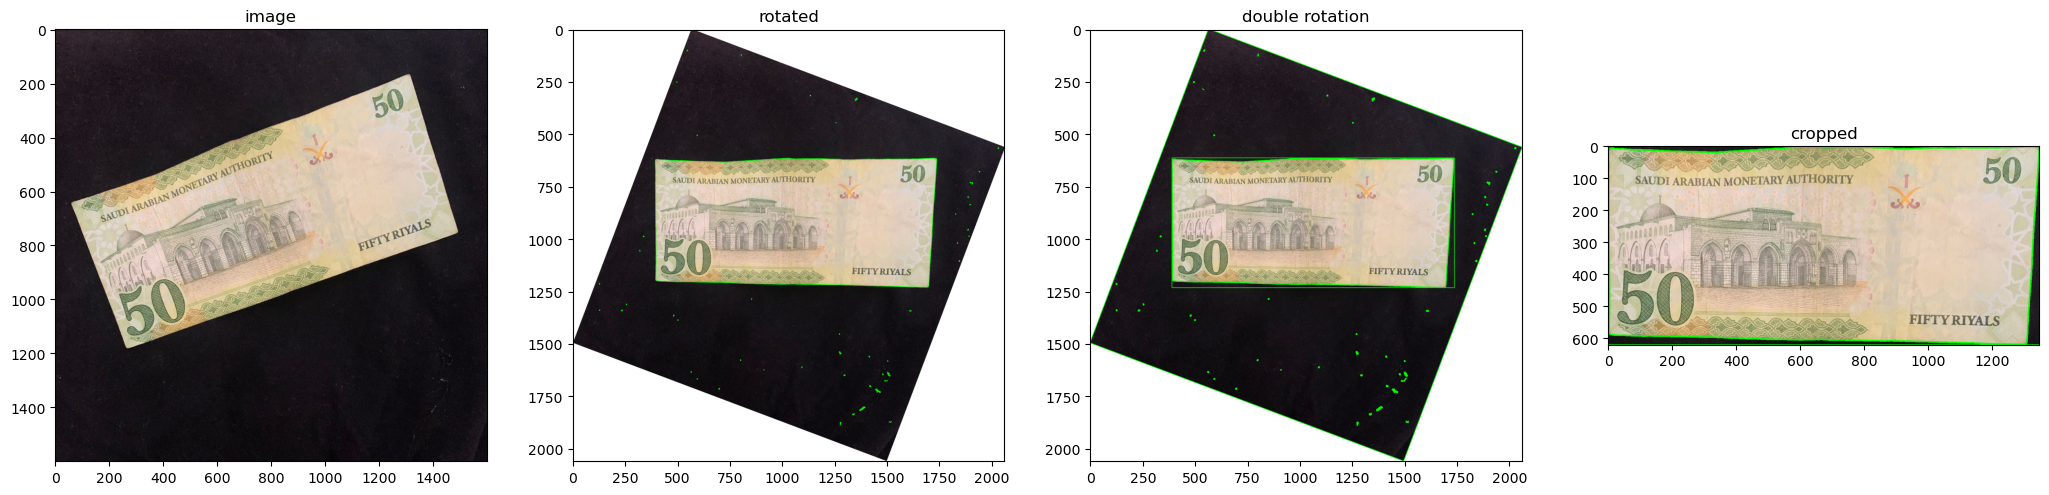

In [700]:
# Read the image
image = io.imread('SAR_Background/50.5.jpg')
#image = io.imread('Test_Images/1.6.jpg')


# Automatically rotate the image
rotated_image, box = auto_rotate_image(image, 0)
#edges = fill_small_holes(image)

#cv2.drawContours(rotated_image, [box], -1, (0, 255, 0), 2)

rotatedd_image, box2 = auto_rotate_image(rotated_image)
cv2.drawContours(rotatedd_image, [box2], -1, (0, 255, 0), 2)

x, y, w, h = cv2.boundingRect(box2)
if w < h:
    w, h = h, w
#Crop the image using the bounding rectangle coordinates
cropped_image = rotatedd_image[y:y + h, x:x + w]

#cv2.imwrite('Test.jpg', cropped_image)

# Display the original and rotated images
show_images([image, rotated_image, rotatedd_image, cropped_image], ['image', 'rotated','double rotation','cropped'])

#5.3, 5.6, 5.8, 10.1, 10.3, 10.5, 10.6, 10.7, 20.1, 50.1, 50.3, 50.4, 50.8, 500.1, 500.3, 500.5
